<a href="https://colab.research.google.com/github/andrecsq/trabalho_simulacao/blob/main/Trabalho_AD_Simulacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Como fazer da forma errada

In [ ]:
beta = 0.5
gamma = 0.3
time_steps = 200

total_population = 1000
initial_infected = 10 

infected = np.zeros(time_steps) 
infected[0] = initial_infected  

In [ ]:
# Recuperação é 1/taxa

for t in range(1, time_steps):    
    susceptible = total_population-infected[t-1]
    
    cured = np.random.binomial(n=infected[t-1], p=gamma)
    new_infected = np.random.binomial(n=susceptible, p=beta)
    
    infected[t] = infected[t-1] - cured + new_infected

susceptible = 1000 - infected

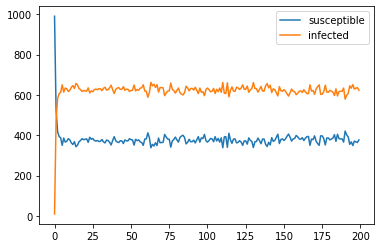

In [ ]:
plt.plot(susceptible, label='susceptible')
plt.plot(infected, label='infected')
plt.legend()

Solução Analítica

In [ ]:
beta = 0.5
gamma = 0.2
total_population = 30
time_steps = 50
initial_infected = 1

I_inf = (1- gamma/beta)*total_population
V = I_inf/initial_infected - 1
x = beta - gamma

def I(t):
  return I_inf / (1 + V*np.exp(-x*t) )

infected_analytic = np.array([I(t) for t in range(0, time_steps)])
susceptible_analytic = total_population - infected_analytic

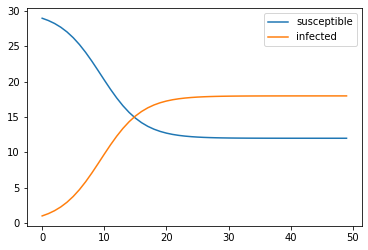

In [ ]:
plt.plot(susceptible_analytic, label='susceptible')
plt.plot(infected_analytic, label='infected')
plt.legend()

## Implementação Eventos

In [ ]:
import queue
from dataclasses import dataclass, field

@dataclass(order=True)
class Event:
  time: float
  event_type: str=field(compare=False)
  x: int=field(compare=False)
  y: int=field(compare=False, default=None)

In [ ]:
def initialize_population_state(total_population, initial_infected):
  pop_state = [False] * total_population
  for i in range(initial_infected):
    pop_state[i] = True
  return pop_state

def initialize_queue(beta, total_population, initial_infected):
  q = queue.PriorityQueue()
  for i in range(total_population):
    for j in range(i+1, total_population):
      encounter_time = np.random.exponential(beta)
      encounter_event = Event(encounter_time, 'encounter', i, j)
      q.put(encounter_event)
  
  for i in range(initial_infected):
    cure_time = np.random.exponential(gamma)
    cure_event = Event(cure_time, 'cure', i)
    q.put(cure_event)

  return q

In [ ]:
# is_infected = initialize_population_state(total_population, initial_infected)
# q = initialize_queue(gamma, total_population)

In [ ]:
def handle_infection(gamma, e, is_infected, q):
  time = e.time
  infected = e.y if is_infected[e.x] else e.x
  infector = e.x if is_infected[e.x] else e.y

  is_infected[infected] = True # Now infected

  cure_time = np.random.exponential(gamma) # Creates random cure time
  cure_event_infected = Event(e.time + cure_time, 'cure', infected) # Create Event objects
  q.put(cure_event_infected) # Add events to queue

  if DEBUG:
    print(f"t:{round(time, 6)} - {infector}->{infected}")

  events.append(Event(time, 'infection', infected, infector))

def generate_new_encounter(beta, e, q):
  encounter_time = e.time + np.random.exponential(beta)
  encounter_event_x_y = Event(encounter_time, 'encounter', e.x, e.y) 
  q.put(encounter_event_x_y)

def handle_cure(e, is_infected):
  is_infected[e.x] = False 
  if DEBUG:
      print(f"t:{round(e.time, 6)} - {e.x} is cured")
  events.append(Event(e.time, 'cure', e.x))

def handle_encounter(beta, gamma, e, is_infected, q, null_encounters):    
  if is_infected[e.x] and not is_infected[e.y]:
    handle_infection(gamma, e, is_infected, q) 
    if DEBUG:
      print(f"{null_encounters} events without infection")
    null_encounters = -1
  generate_new_encounter(beta, e, q)
  return null_encounters + 1

In [ ]:
events = []

def simulate_epidemic(beta, gamma, total_population, initial_infected, max_time):
  is_infected = initialize_population_state(total_population, initial_infected)
  q = initialize_queue(beta, total_population, initial_infected)
  times = []
  amount_infected = []


  null_encounters = 0
  while not q.empty():
    e = q.get()
    
    if e.time > max_time:
      return times, amount_infected
      break
    if e.event_type == 'encounter':
      null_encounters = handle_encounter(beta, gamma, e, is_infected, q, null_encounters)
    elif e.event_type == 'cure':
      handle_cure(e, is_infected)

    times.append(e.time)
    amount_infected.append(sum(is_infected))

In [ ]:
beta = 0.5
gamma = 0.1

total_population = 50
initial_infected = 1 
DEBUG = True

In [ ]:
# Input: Network G, transmission rate per edge τ, recovery rate γ, set of index node(s)
#   initial infecteds, and maximum time tmax.
# Output: t: list of times and I: list containing number infected at each time.

# function fast_SIS(G,τ, γ, initial infecteds, tmax)
#   initialise Q, node statuses and return variables as in fast SIR, but include a source for infections with recovery time 0.
#   while Q is not empty do
#     Event ← earliest remaining event in Q
#     if Event.action is transmit then
#       if Event.node.status is susceptible then
#         process_trans_SIS(G, Event.node, Event.time, τ, γ, times, S, I, Q, tmax) 
#       find_next_trans_SIS(Q, Event.source, Event.node, t)  # needed for SIS model <--- Não entendi isso. Por que ele transmite de novo?
#     else
#       process rec_SIS(Event.node, t, S, I) # Apenas recupera o node
#   return times, S, I

# function process_trans_SIS(G, u, t, τ, γ, times, S, I, Q, tmax)
#   append_times, S, and I with t, S.last−1, and I.last+1
#   u.status ← infected
#   u.rec_time ← t+exponential variate(γ)
#   if u.rec_time < tmax then
#     newEvent ← {node: u, time: u.rec_time, action: recover}
#     push(Q, newEvent)
#   for v in G.neighbours(u) do
#     find_next_trans_SIS(Q, t, τ, u, v, tmax)

# function find_next_trans_SIS(Q, t, τ, source, target, tmax)
#   - Se o alvo se recuperar antes da fonte
#   if target.rec_time < source.rec_time then
#     transmission_time = max(t, target.rec_time)+exponential_variate(τ) 
#     if transmission_time < source.rec_time then # E o tempo da transmissão é antes da fonte se recuperar
#       newEvent ← {node: target, time: transmission_time, action: transmit, source: source} 
#       push(Q, newEvent) # cria novo evento de transmissão

# function process_rec_SIS(u, times, S, I)
#   append times, S, and I with t, S.last+1, and I.last−1
#   u.status ← susceptible

In [ ]:
times, amount_infected = simulate_epidemic(beta, 
                                          gamma, 
                                          total_population,
                                          initial_infected,
                                          0.5)

t:0.012738 - 0->22
31 events without infection
t:0.014047 - 0->21
2 events without infection
t:0.018486 - 22->28
10 events without infection
t:0.020787 - 28->13
3 events without infection
t:0.020874 - 21->40
0 events without infection
t:0.021939 - 0->11
1 events without infection
t:0.025219 - 21->4
6 events without infection
t:0.025912 - 40->35
1 events without infection
t:0.026033 - 4->45
0 events without infection
t:0.026127 - 22->1
0 events without infection
t:0.026506 - 40->30
0 events without infection
t:0.026801 - 0->44
1 events without infection
t:0.027586 - 45->37
2 events without infection
t:0.027819 - 13->41
0 events without infection
t:0.03054 - 28->8
3 events without infection
t:0.032129 - 28 is cured
t:0.035 - 35->5
11 events without infection
t:0.035301 - 45->6
0 events without infection
t:0.035315 - 11->39
0 events without infection
t:0.035862 - 5->42
1 events without infection
t:0.036558 - 41->20
1 events without infection
t:0.038888 - 39->32
5 events without infection


In [ ]:
print(times[:10])
print(amount_infected[:10])

[0.0014489250318102615, 0.0017507787783196849, 0.0017859336956722277, 0.0018985338513801662, 0.0019338955380042435, 0.003010617719742772, 0.003444245784519236, 0.003769481857333617, 0.003964244724627581, 0.0054350083080321925]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print()

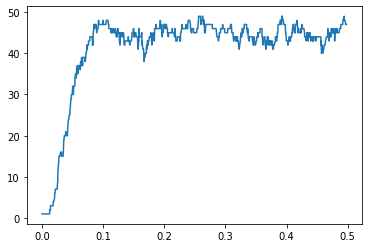

In [ ]:
plt.plot(times, amount_infected)

In [ ]:
# for i in range(len(times)):
#   print(f"{times[i]}:{amount_infected[i]}")